In [1]:
import torchvision
from torchvision import datasets
from torchvision.transforms import transforms

import torch
from torch import nn
from torch.nn import functional as F
from torchmetrics import Accuracy

import numpy as np

from resnet import resnet18

In [2]:
n_labeled = 16384

# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Normalize((0.5, ), (0.5, ))])
# dataset_train = datasets.MNIST(root = "../data", transform = transform, train = True, download = True)
# dataset_train = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), size = (n_labeled,)))
# dataset_test = datasets.MNIST(root = "../data", transform = transform, train = False, download = True)

# input_ch = 1
# dataset_name = "MNIST"

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])
dataset_train = datasets.CIFAR10(root = "../data", transform = transform, train = True, download = True)
dataset_train = torch.utils.data.Subset(dataset_train, np.random.choice(len(dataset_train), size = (n_labeled,)))
dataset_test = datasets.CIFAR10(root = "../data", transform = transform, train = False, download = True)

input_ch = 3
image_size = 32
dataset_name = "CIFAR10"

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from tqdm import tqdm

n_trials = 6
batch_size = 512

train_dl = torch.utils.data.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

test_dl = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False, num_workers=0)

class Network(nn.Module):
    
    def __init__(self, hidden_dim = 1024):
        
        super().__init__()

        self.hidden_dim = hidden_dim
        
#         self.net = torch.nn.Sequential(
#             resnet18(
#                 num_classes = self.hidden_dim,
#                 zero_init_residual = False,
#                 conv1_type = "cifar",
#                 no_maxpool = True,
#                 norm_layer = nn.InstanceNorm2d,
#                 input_ch = input_ch
#             ),
#             torch.nn.ReLU(),
#         )
#         self.model_type = "ResNet18"
        
        self.net = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(
                image_size * image_size * input_ch,
                self.hidden_dim),
            torch.nn.ReLU(),
#             torch.nn.Dropout(),
        )
        
        self.model_type = "Shallow"

        self.head = torch.nn.Sequential(
            torch.nn.Linear(self.hidden_dim, 10)
        )
        
    def forward(self, x):
        return self.head(self.net(x))

device = torch.device('cuda:0')
lossFn = nn.CrossEntropyLoss()
accFn  = Accuracy()

trial_logits = []

for i in range(n_trials):
    
    print("Trial %d" % (i + 1))
    
    hidden_dim = 2048
    net = Network(hidden_dim)
    
    optim = torch.optim.AdamW(net.parameters())
    
    net = net.to(device)
    net.train()
    
    for ep in tqdm(range(100)):
        for batch in train_dl:
            
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            
#             print(y)
            
            output = net(x)
            loss = lossFn(output, y)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
    
    # Obtain results
    net.eval()
    accuracy = 0
    cnt = 0
    logits = []
    for batch in test_dl:
        x, y = batch
        x = x.to(device)
        
        output = net(x)
        logits.append(output.detach().cpu())
        
        preds = torch.argmax(output, dim=1)
        accuracy += accFn(preds.detach().cpu(), y)
        
        cnt += 1
        
    logits = torch.cat(logits, dim = 0)
    trial_logits.append(logits)
    
    accuracy /= cnt
    print("Final accuracy: %.2f" % (accuracy * 100.0))

Trial 1


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.09s/it]


Final accuracy: 48.28
Trial 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:48<00:00,  1.08s/it]


Final accuracy: 48.53
Trial 3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:49<00:00,  1.09s/it]


Final accuracy: 47.73
Trial 4


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:51<00:00,  1.11s/it]


Final accuracy: 48.14
Trial 5


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


Final accuracy: 48.13
Trial 6


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:52<00:00,  1.13s/it]


Final accuracy: 48.02


In [4]:
# Results with activations
net.eval()
activation = []
for batch in test_dl:
    x, y = batch
    x = x.to(device)

    z = net.net(x)
    out = (z.unsqueeze(1) * net.head[0].weight.unsqueeze(0)).squeeze().detach().cpu()
    
    activation.append(out)

activation = torch.cat(activation)
print(activation.shape)
activation_std = activation.std(2)
print(activation_std.shape)

torch.Size([10000, 10, 2048])
torch.Size([10000, 10])


In [5]:
nza_count = (activation != 0).sum(2, keepdims = True)
nza_mean = activation.sum(2, keepdims = True) / nza_count
nza_var = (((activation - nza_mean) * (activation != 0)) ** 2).sum(2) / (nza_count.squeeze() - 1)
nza_std = torch.sqrt(nza_var)
print(nza_std.shape)
print(nza_std)
# nza_mean = 

torch.Size([10000, 10])
tensor([[0.1985, 0.1950, 0.1658,  ..., 0.2008, 0.1919, 0.2508],
        [0.1566, 0.2205, 0.2128,  ..., 0.2585, 0.1711, 0.1902],
        [0.1387, 0.1799, 0.1661,  ..., 0.1909, 0.1474, 0.1827],
        ...,
        [0.2773, 0.2679, 0.1908,  ..., 0.1955, 0.2581, 0.2785],
        [0.2267, 0.2053, 0.1874,  ..., 0.1893, 0.1862, 0.2289],
        [0.1176, 0.1272, 0.1026,  ..., 0.1196, 0.1659, 0.1648]])


In [6]:
torch.save(trial_logits, "%dtrial_logits_%s(%d)_%s-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, net.hidden_dim))
torch.save(activation, "%dacts_logits_%s(%d)_%s-%d.pkl" % (n_trials, dataset_name, n_labeled, net.model_type, net.hidden_dim))

In [7]:
trial_logits_t = torch.stack(trial_logits, dim = 0)
trial_std = trial_logits_t.std(dim = 0)
print(trial_std.shape)

torch.Size([10000, 10])


In [8]:
# print(dataset_test.targets)

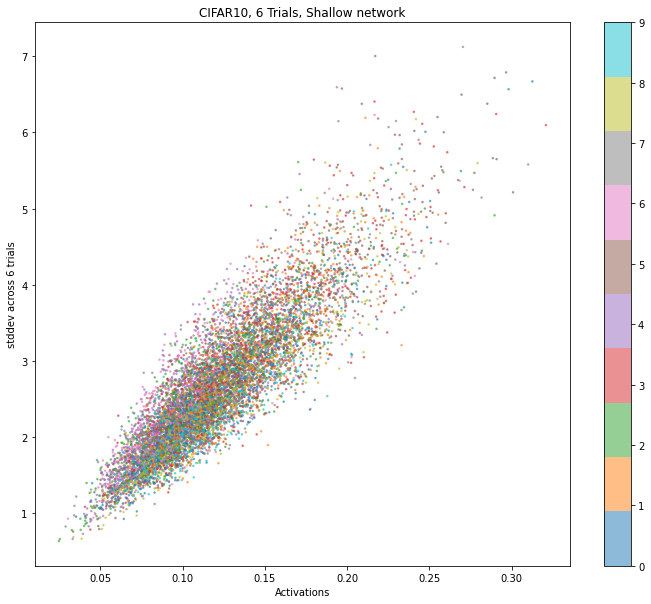

In [9]:
from matplotlib import pyplot as plt
plt.figure(figsize = (12, 10))

colorbar = plt.scatter(
#     nza_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    activation_std.mean(dim = 1), trial_std.mean(dim = 1), alpha = 0.5, marker = '.',
    s = 10, c = dataset_test.targets, cmap = "tab10")
plt.colorbar(colorbar)
plt.xlabel("Activations")
plt.ylabel("stddev across %d trials" % (n_trials))
plt.title("%s, %d Trials, %s network" % (dataset_name, n_trials, net.model_type))

plt.savefig("%dtrials_%s(%d)_%s-%d.png" % (n_trials, dataset_name, n_labeled, net.model_type, net.hidden_dim))
plt.show()